Setup for packages and loading the data.

The dataset is a csv file, for each named file there's 24 columns: a label which can be 1 or 2 (1 for SSP, 2 for star) and 23 colour index. 

The data was queried from J-PLUS DR1 database and tidied up to remove duplicates and rows with null values for magnitudes. Magnitudes were converted to colour index with rSDSS as reference, and objects with probability of being star less than 1.0 were dropped. This objects were classified as label 2. Additional data was acquired via magnitude convolution for SSPs and classified as label 1. Labels were renamed as SSP (1) or star (2).

Cuts on data were applied: first to consider only optimal range where GCs can be found (between 0.1 and 1.0 g-r colour) and then to guarantee 10% GC to 90% stars sample population.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import graphviz

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = '16'
#sns.set_theme('seaborn-whitegrid')

fname = "./catalog/fulldata.csv"
jplusColours = pd.read_csv(fname, index_col='id')

jplusColours.label.replace([1, 2], ["ssp","star"], inplace=True)

features = ['u-r', 'J378-r', 'J395-r', 'J410-r', 'J430-r', 'g-r', 'J515-r', 'r-J660', 'r-i', 'r-J861', 'r-z']

jplusCut = jplusColours[(jplusColours["g-r"] > 0.1) & (jplusColours["g-r"] < 1.0)]

ssp = jplusCut[jplusCut['label'] == 'ssp']
n_ssp = ssp.shape[0]
pcent = 0.1
n_star = int(n_ssp/pcent) - n_ssp
star = jplusCut[jplusCut['label'] == 'star'].sample(n_star)
data = star.append(ssp)

We define functions to train the models. Each function splits the dataset in training and testing sets (60% and 40% each). The code uses cross-validation to seek for the best parameters to avoid overfitting.

In [2]:
def decTree(dataset, features, depth=None):
    X = dataset[features]
    y = dataset["label"]
    
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.4)
    
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(xtrain, ytrain)
    scores = cross_val_score(model, xtest, ytest, cv=5)
    
    return model, scores

def forest(dataset, features, depth=None):
    
    X = dataset[features]
    y = dataset["label"]
    
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.4)
    model = RandomForestClassifier()
    model.fit(xtrain, ytrain)
    scores = cross_val_score(model, xtest, ytest, cv=5)
    
    return model, scores

We first compare the scoring of models according to tree and forest depth, plotting each score with associated standard deviation against depth.

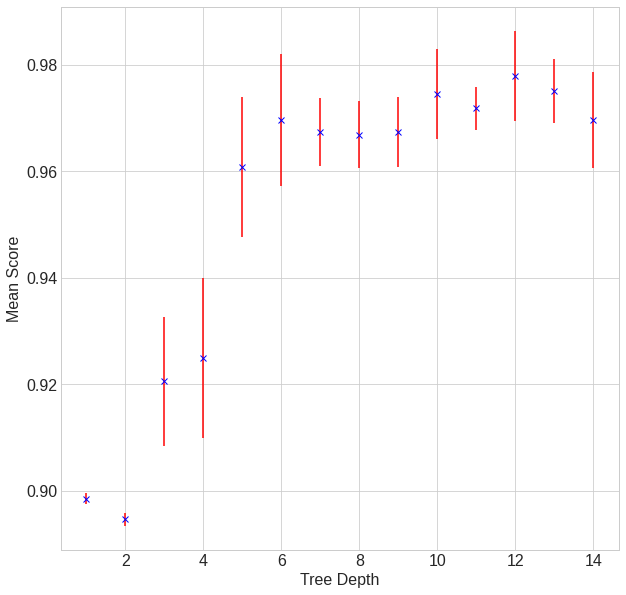

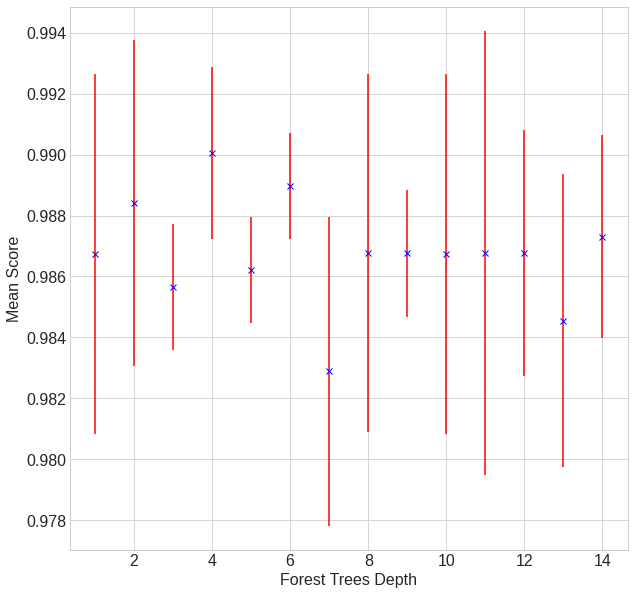

In [3]:
ndep = np.arange(1,15)
tsc = np.zeros([14,2])
fsc = np.zeros([14,2])
for i in ndep:
    #print("Depth = ", i)
    tmodel, tscores = decTree(data, features, i)
    tsc[i-1, :] = [tscores.mean(), tscores.std()]
    fmodel, fscores = forest(data, features, i)
    fsc[i-1, :] = [fscores.mean(), fscores.std()]

plt.figure(figsize=(10,10))
plt.xlabel("Tree Depth")
plt.ylabel("Mean Score")
plt.errorbar(x=ndep, y=tsc[:,0], yerr=tsc[:,1], fmt="bx", ecolor="r")
plt.show()
plt.figure(figsize=(10,10))
plt.xlabel("Forest Trees Depth")
plt.ylabel("Mean Score")
plt.errorbar(x=ndep, y=fsc[:,0], yerr=fsc[:,1], fmt="bx", ecolor="r")
plt.show()

Tree models are run with different feature lists, to see their behaviour with our sample. First considering the complete feature list.

Score:  1.0  #  0.0


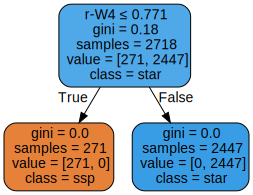

In [21]:
features = list(data.columns[1:])
treeModel, scores = decTree(data, features, depth=6)
print("Score: ", scores.mean(), " # ", scores.std())
dot_data = export_graphviz(treeModel, out_file=None,
                           feature_names=features,
                           class_names=["ssp", "star"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data, format="png")
graph

Now only considering J-PLUS and 2MASS mags.

Score:  0.9977900552486189  #  0.003221520383892446


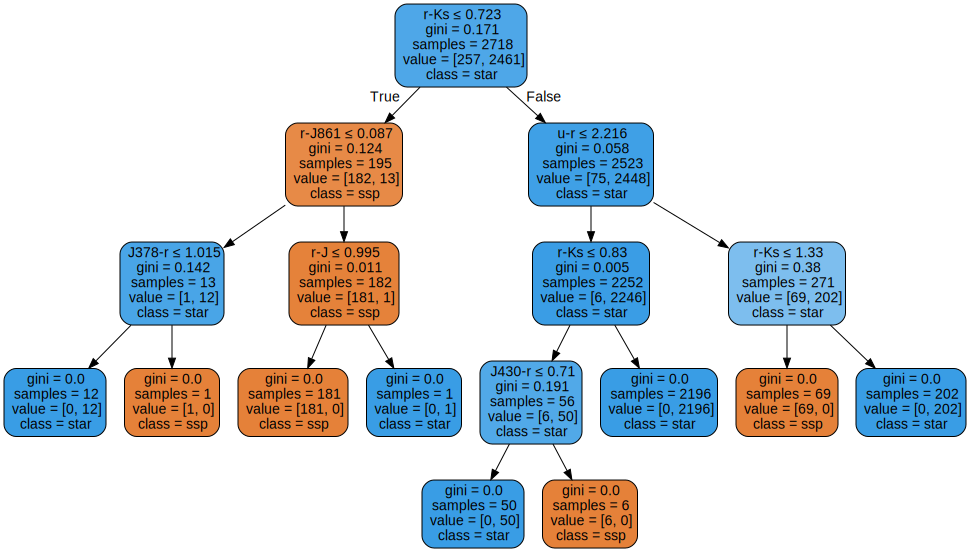

In [18]:
features = ['u-r', 'J378-r', 'J395-r', 'J410-r', 'J430-r', 'g-r', 'J515-r', 'r-J660', 'r-i', 'r-J861', 'r-z', 'r-J', 'r-H', 'r-Ks']

treeModel, scores = decTree(data, features, depth=6)
print("Score: ", scores.mean(), " # ", scores.std())
dot_data = export_graphviz(treeModel, out_file=None,
                           feature_names=features,
                           class_names=["ssp", "star"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data, format="png")
graph

Now only using features from J-PLUS mag.

Score:  0.9646850219929075  #  0.007245313333428864


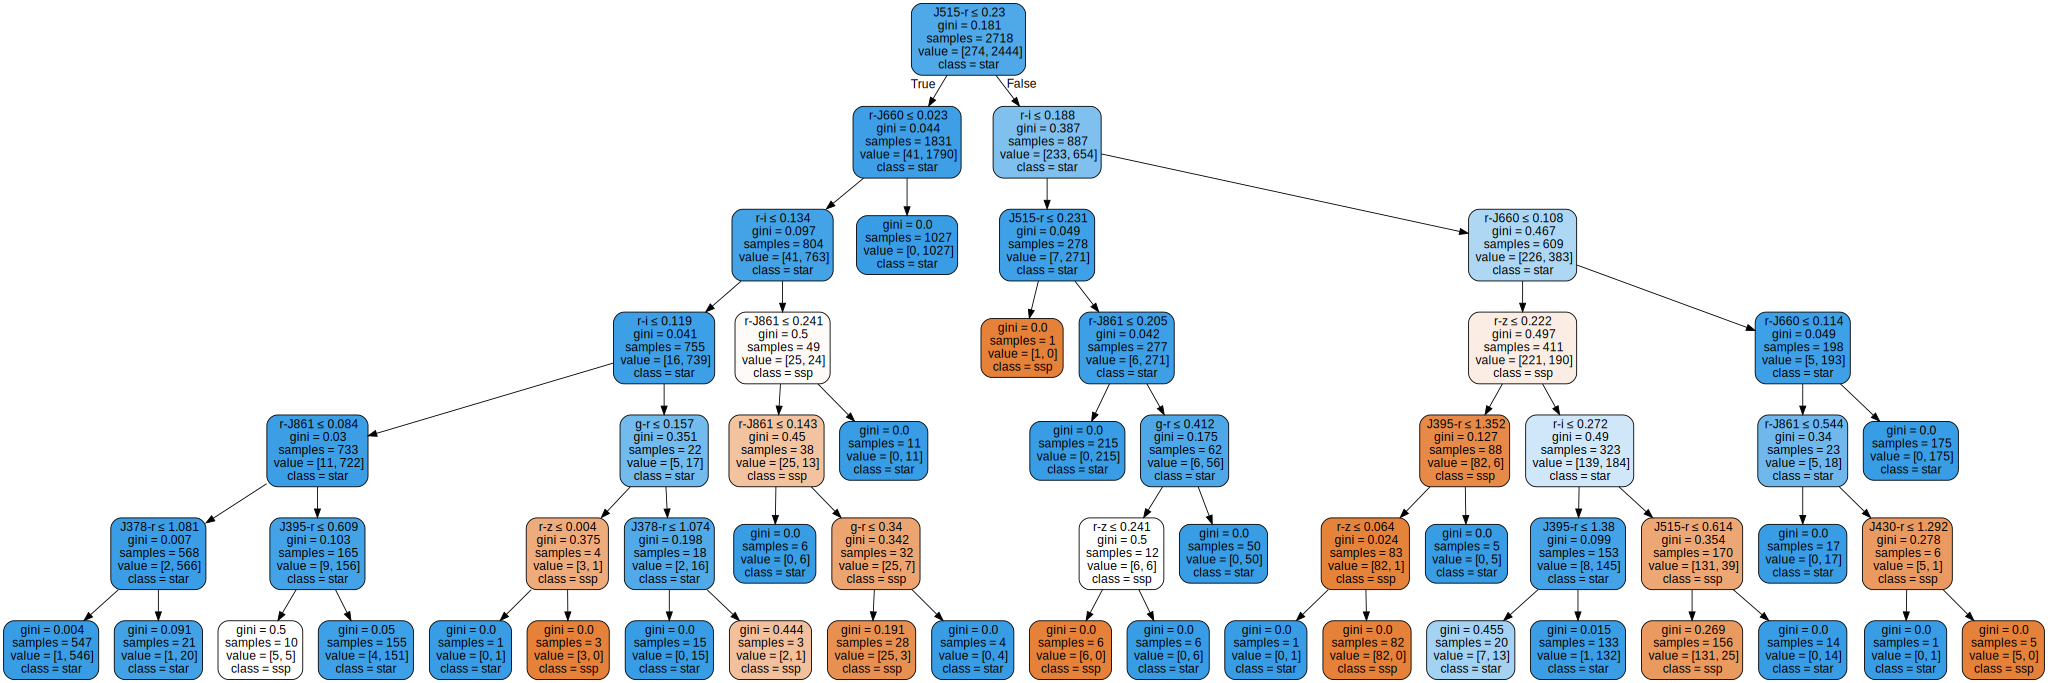

In [16]:
features = ['u-r', 'J378-r', 'J395-r', 'J410-r', 'J430-r', 'g-r', 'J515-r', 'r-J660', 'r-i', 'r-J861', 'r-z']
treeModel, scores = decTree(data, features, depth=6)
print("Score: ", scores.mean(), " # ", scores.std())
dot_data = export_graphviz(treeModel, out_file=None,
                           feature_names=features,
                           class_names=["ssp", "star"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data, format="png")
graph

Now plotting relationship between colour indexes and how SSPs appear.

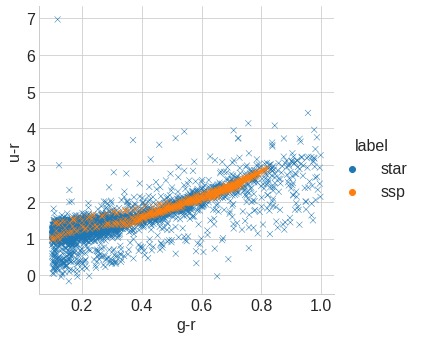

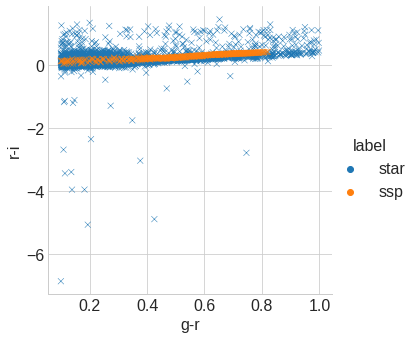

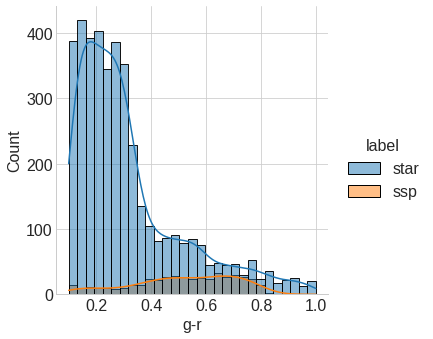

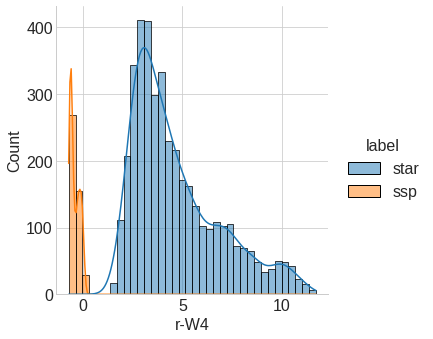

In [7]:
sns.relplot(
    data=data,
    x="g-r", y="u-r", hue="label",
    palette="tab10", marker="x"
)
sns.relplot(
    data=data,
    x="g-r", y="r-i", hue="label",
    palette="tab10", marker="x"
)
sns.displot(
    data=data,
    x="g-r",hue="label",
    palette="tab10", kde=True
)
sns.displot(
    data=data,
    x="r-W4",hue="label",
    palette="tab10", kde=True
)

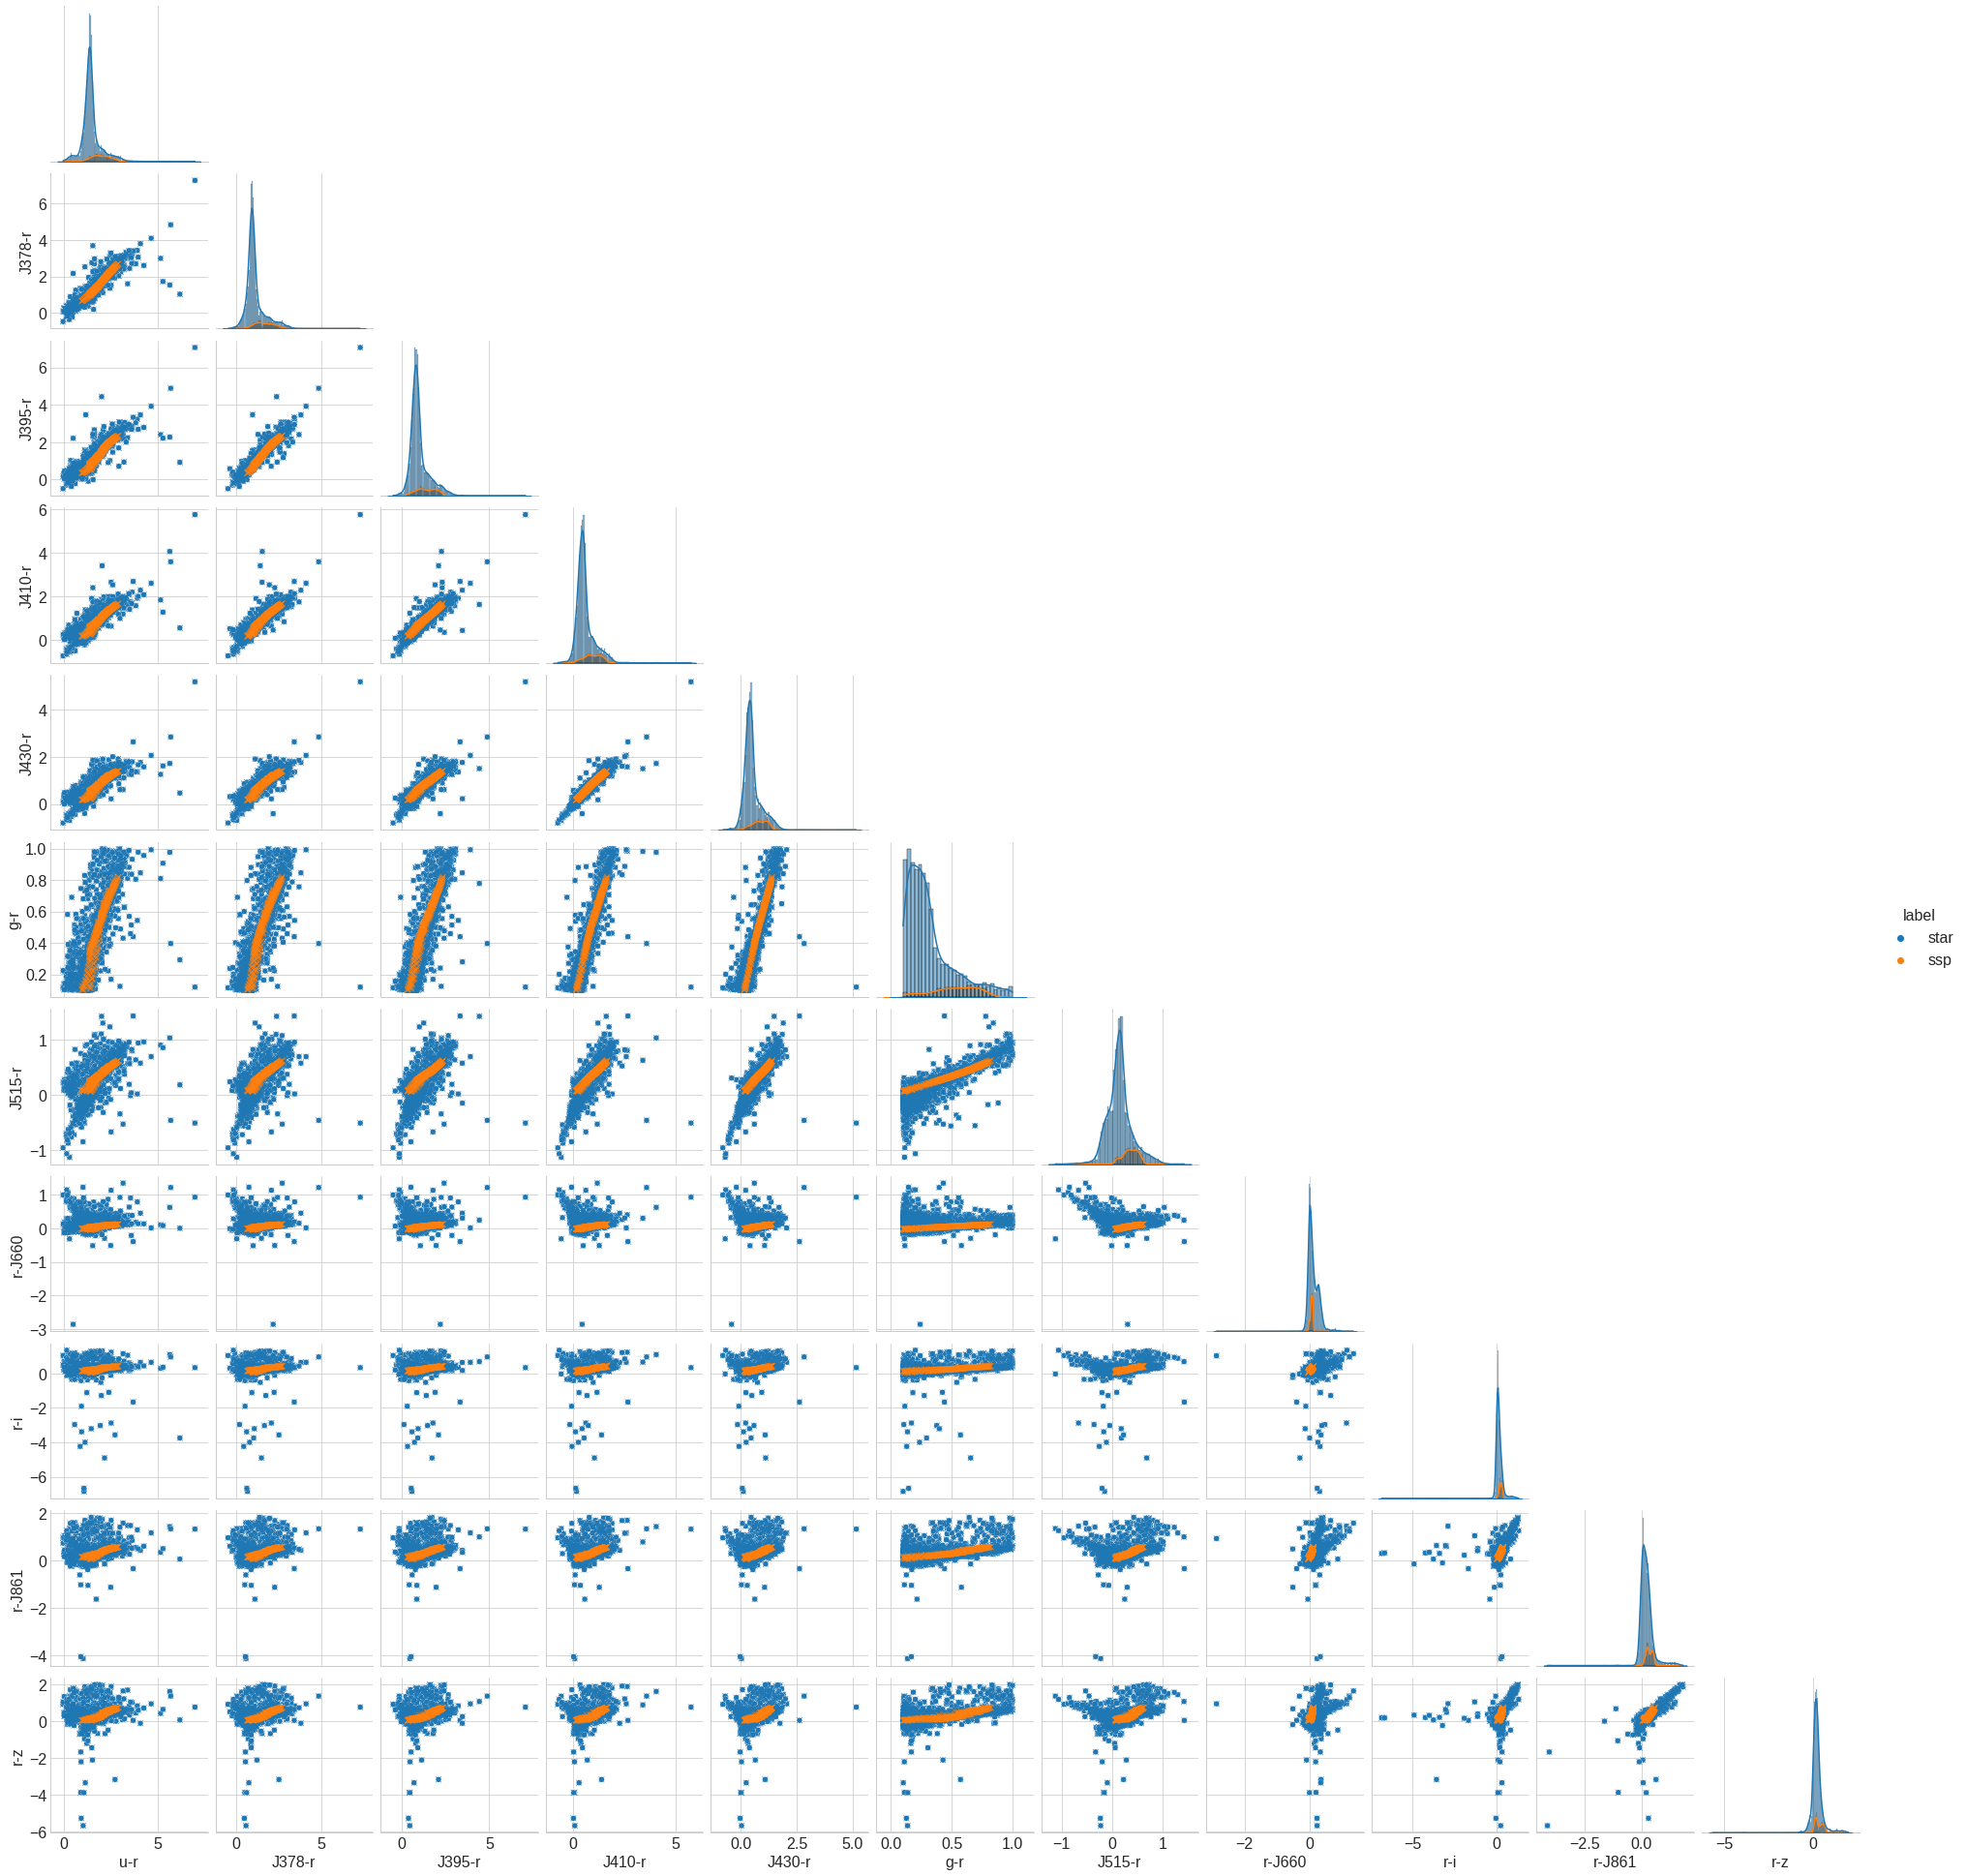

In [27]:
g = sns.pairplot(
    data = data,
    x_vars=features,
    y_vars=features,
    hue="label", palette="tab10", 
    corner=True)
g.map_lower(sns.scatterplot, marker="x")
g.map_diag(sns.histplot, kde=True)